# I. Introduction

![Simulated Annealing](SA_animation.gif)
As illustrated in the lectures, simulated annealing is a probablistic technique used for finding an approximate solution to an optimization problem.  In this exercise you will check your understanding by implementing [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) to solve the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between US state capitals.  Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

Image Source: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

## Overview

Students should read through the code, then:

  0. Implement the `simulated_annealing()` main loop function in Section II
  0. Complete the `TravelingSalesmanProblem` class by implementing the `successors()` and `get_value()` methods in section III
  0. Complete the `schedule()` function to define the temperature schedule in Section IV
  0. Use the completed algorithm and problem description to experiment with simulated annealing to solve larger TSP instances on the map of US capitals

In [8]:
import json
import copy

import numpy as np  # contains helpful math functions like numpy.exp()
import numpy.random as random  # see numpy.random module
# import random  # alternative to numpy.random module

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import sys
!pip3 install math
import math
print("{}".format(sys.version))
# show Python 2.7 executable directory
!which pip
# show Python 3.6 executable directory
!which pip3
# show jupyter config paths http://jupyter.readthedocs.io/en/latest/projects/jupyter-directories.html
!jupyter --paths

  Using cached Math-0.5.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/private/var/folders/8q/kll0jy354kj5gxrv9n0pwx300000gn/T/pip-build-jtvcpmcx/math/setup.py", line 2, in <module>
        raise RuntimeError("Package 'Math' must not be downloaded from pypi")
    RuntimeError: Package 'Math' must not be downloaded from pypi
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/8q/kll0jy354kj5gxrv9n0pwx300000gn/T/pip-build-jtvcpmcx/math/
3.6.0 (v3.6.0:41df79263a11, Dec 22 2016, 17:23:13) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
/Users/Ls/miniconda3/bin/pip
/Library/Frameworks/Python.framework/Versions/3.6/bin/pip3
config:
    /Users/Ls/.jupyter
    /Library/Frameworks/Python.framework/Versions/3.6/etc/jupyter
    /usr/local/etc/jupyter
    /etc/jupyter
data:
    /Users/Ls/Library/Jupyter
    

In [9]:
"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# Please go to http://www.usgs.gov/visual-id/credit_usgs.html for further information
map = mpimg.imread("map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())

def show_path(path, starting_city, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

## II. Simulated Annealing -- Main Loop

The main loop of simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.  See the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) pseudocode from the AIMA textbook online at github.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [10]:
def simulated_annealing(problem, schedule):
    """The simulated annealing algorithm, a version of stochastic hill climbing
    where some downhill moves are allowed. Downhill moves are accepted readily
    early in the annealing schedule and then less often as time goes on. The
    schedule input determines the value of the temperature T as a function of
    time. [Norvig, AIMA Chapter 3]
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
        
    Notes
    -----
        (1) DO NOT include the MAKE-NODE line from the AIMA pseudocode

        (2) Modify the termination condition to return when the temperature
        falls below some reasonable minimum value (e.g., 1e-10) rather than
        testing for exact equality to zero
        
    See Also
    --------
    AIMA simulated_annealing() pseudocode
        https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md
    
    AIMA simulated_annealing() sample code
        https://github.com/aimacode/aima-python/blob/master/search.py
    """
    !pip3 install math
    import math

    min_T = 1e-10            # 0.0000000001
    ct = 1                   # iteration
    current_state = problem  # initial problem state
    delta_E = 0              # represents change in the score E
    
    def random_pick_for_probability(states, probabilities):
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for item, item_probability in zip(states, probabilities):
            cumulative_probability += item_probability
            if x < cumulative_probability: break
        return item
    
    while True:
        T = schedule(ct)
        
        # as temperature approaches 0 return early when temperature
        # falls below termination condition value
        # (since temperature reaching 0 gives undefined answer)
        if T < min_T:
            return current_state 
        
        successors = problem.successors()
        
        # select positions randomly from neighboring region
        next_index = random.randint(0, len(successors))
        next_state = successors[next_index]
        delta_E = next_state.get_value() - current_state.get_value()
        
        # if new random position improves score E (up the gradient)
        # then select it (up the gradient)
        if delta_E > 0:
            current_state = next_state
        
        # if new random position lessons score E (down the gradient)
        # then select it based on a probability
        # reference: https://www.safaribooksonline.com/library/view/python-cookbook-2nd/0596007973/ch04s22.html
        else:
            prob = math.exp(delta_E/T)
            current_state = random_pick_for_probability( \
                            [current_state, next_state], [1-prob, prob])
        ct += 1
    

## III. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [11]:
class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.
    
    Students should only need to implement or modify the successors() and
    get_values() methods.
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)
        
        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        successor_problems = []
        current_path = self.path
        path_length = len(current_path)
        
        for i in range(0, path_length):
            new_path = copy.deepcopy(self.path)
            new_path[i], new_path[(i + 1) % path_length] = new_path[(i + 1) % path_length], new_path[i]
            successor_problems.append(TravelingSalesmanProblem(new_path))
            
        return successor_problems
        

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.  Since
        the default simulated annealing algorithm seeks to maximize the objective
        function, return -1x the path length. (Multiplying by -1 makes the smallest
        path the smallest negative number, which is the maximum value.)
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        Notes
        -----
            (1) Remember to include the edge from the last city back to the
            first city
            
            (2) Remember to multiply the path length by -1 so that simulated
            annealing finds the shortest path
        """
        current_path = self.path
        path_length = len(current_path)
        cost_total = 0
        
        for i in range(0, path_length):
            current_city_coords = np.array(current_path[i % path_length][1])
            next_city_coords = np.array(current_path[(i + 1) % path_length][1])
            cost_total += np.sqrt(np.sum(np.square(current_city_coords - next_city_coords)))
            
            # Alternative:
            # x1, y1 = self.coords[i]
            # x2, y2 = self.coords[(i + 1) % path_length]
            # cost_total += math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        return -cost_total     

### Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `successors()` and `get_value()` methods.

In [12]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [13]:
# Test the successors() method -- no output means the test passed
successor_paths = [x.path for x in tsp.successors()]
assert(all(x in [[('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3)), ('DC', (11, 1))],
                 [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3))]]
          for x in successor_paths))

In [14]:
# Test the get_value() method -- no output means the test passed
assert(np.allclose(tsp.get_value(), -28.97, atol=1e-3))

## IV. Define the Temperature Schedule

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$

(Note that this is equivalent to the incremental form $T_{i+1} = \alpha T_i$, but implementing that form is slightly more complicated because you need to preserve state between calls.)

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions.

You can also experiment with other schedule functions -- linear, quadratic, etc.  Think about the ways that changing the form of the temperature schedule changes the behavior and results of the simulated annealing function.

In [15]:
# These are presented as globals so that the signature of schedule()
# matches what is shown in the AIMA textbook; you could alternatively
# define them within the schedule function, use a closure to limit
# their scope, or define an object if you would prefer not to use
# global variables
alpha = 0.95
temperature=1e4

def schedule(time):
    return (alpha ** time) * temperature

### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [16]:
# test the schedule() function -- no output means that the tests passed
assert(np.allclose(alpha, 0.95, atol=1e-3))
assert(np.allclose(schedule(0), temperature, atol=1e-3))
assert(np.allclose(schedule(10), 5987.3694, atol=1e-3))

In [17]:
# Failure implies that the initial path of the test case has been changed
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])
result = simulated_annealing(tsp, schedule)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.get_value(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.get_value(), result.path))
assert(tsp.path != result.path)
assert(result.get_value() > tsp.get_value())

  Using cached Math-0.5.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/private/var/folders/8q/kll0jy354kj5gxrv9n0pwx300000gn/T/pip-build-ek200aw5/math/setup.py", line 2, in <module>
        raise RuntimeError("Package 'Math' must not be downloaded from pypi")
    RuntimeError: Package 'Math' must not be downloaded from pypi
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/8q/kll0jy354kj5gxrv9n0pwx300000gn/T/pip-build-ek200aw5/math/
Initial score: -28.970026243745615
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: -27.130286796483155
Final Path: [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))]


## V. Run Simulated Annealing on a Larger TSP
Now we are ready to solve a TSP on a bigger problem instance by finding a shortest-path circuit through several of the US state capitals.

You can increase the `num_cities` parameter up to 30 to experiment with increasingly larger domains.  Try running the solver repeatedly -- how stable are the results?

Initial path value: 3074.15
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0])]
  Using cached Math-0.5.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/private/var/folders/8q/kll0jy354kj5gxrv9n0pwx300000gn/T/pip-build-6t1w4afy/math/setup.py", line 2, in <module>
        raise RuntimeError("Package 'Math' must not be downloaded from pypi")
    RuntimeError: Package 'Math' must not be downloaded from pypi
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/8q/kll0jy354kj5gxrv9n0pwx300000gn/T/pip-build-6t1w4afy/math/
Final path length: 269

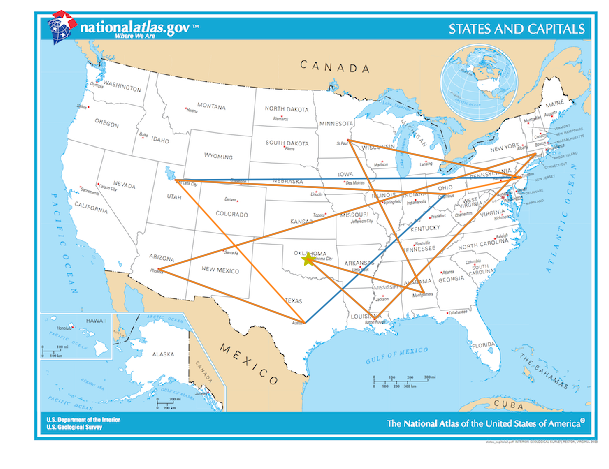

In [18]:
# Create the problem instance and plot the initial state
num_cities = 10
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

# set the decay rate and initial temperature parameters, then run simulated annealing to solve the TSP
alpha = 0.99
temperature=1e6
result = simulated_annealing(capitals_tsp, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)

### Experiments (Optional)
Here are some ideas for additional experiments with various settings and parameters once you've completed the lab.

- Change the number of cities in the final map (between 10 and 30).  How are your results affected?  Why?
- Change the alpha and temperature parameters.  How do they affect the results?
- Use a different schedule function (something other than exponential decay).  Is the algorithm still effective?
- Use a different successors function; e.g., generate successors of a state by swapping _any_ pair of cities in the path, rather than only adjacent cities.  Try defining your own successor function.  What effect does the change have?
- Use a different distance metric for get_value (e.g., we used the L2-norm (Euclidean distance), try the L1-norm (manhattan distance) or L$\infty$-norm (uniform norm)

Share and discuss your results with others in the forums!